In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.linalg as scilin
from scipy import special
import matplotlib as mpl
import statsmodels.api as sm
from pandas_datareader import data as pd_data


/home/sangrey/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
volatility_store = pd.HDFStore('../results/spy_volatility_estimates_2003-2014.hdf')
discrete_vol = volatility_store['discrete_trunc_vol']
daily_rtn = volatility_store['daily_rtn']

In [3]:
%matplotlib inline
np.set_printoptions(precision=4)
pd.options.display.precision = 4
mpl.pyplot.style.use('seaborn-talk')
# mpl.rc('text', usetex=True, **{'latex.preamble' : [r'\usepackage{mathtools}', r'\usepackage{amsmath}',
#                                                    r'\usepackage[cm]{sfmath}', r'\usepackage{xcolor}']})
# presentation_fontsize=22
# mpl.rc('font', **{'family':'sans-serif', 'sans-serif':'cm'})
# mpl.rc('legend', **{'fontsize':presentation_fontsize})
# mpl.rc('axes', **{'labelsize':presentation_fontsize, 'titlesize':presentation_fontsize})
# mpl.rc('xtick', **{'labelsize':presentation_fontsize})
# mpl.rc('ytick', **{'labelsize': presentation_fontsize})
# cmap = mpl.cm.get_cmap('Set1', lut=9)
# colors = {'diffusion': 'blue', 'jumps': 'red', 'price':'purple'}

In [4]:
cointegration_results = sio.loadmat('../results/cointegration_estimates.mat')

In [95]:
# cointegration_results

In [96]:
cointegration_results['savevals'][0]

array([ (array([[ 0.726,  0.726]]), array([[-0.2472],
       [-0.0012]]), array([[ 1.    ],
       [-1.2212]]), array([], shape=(0, 0), dtype=uint8), array([[-0.2472,  0.3019],
       [-0.0012,  0.0014]]), array([[ 0.0992,  0.0611],
       [ 0.0611,  0.0522]]), array([[  1.1852e-02,  -2.5680e-01,   4.2800e-02,  -7.1561e-02,
         -3.6284e-01,   3.9828e-02,  -1.4042e-01,   7.1352e-01],
       [  3.3240e-01,  -7.3558e-01,   3.2330e-01,  -5.0731e-01,
         -1.2371e-01,  -2.2497e-01,   1.6157e-04,   2.3326e-01]]), array([], shape=(0, 0), dtype=uint8), array([[ 0.9285,  0.8816]]))], 
      dtype=[('db', 'O'), ('alphaHat', 'O'), ('betaHat', 'O'), ('rhoHat', 'O'), ('PiHat', 'O'), ('OmegaHat', 'O'), ('GammaHat', 'O'), ('xiHat', 'O'), ('muHat', 'O')])

In [97]:
alpha = cointegration_results['savevals'][0][0][2]

In [98]:
alpha_comp = scilin.orth(alpha)

In [101]:
trend = discrete_vol.dropna().dot(alpha_comp).rename(columns={0:'trend'})

In [102]:
pd.concat([discrete_vol, trend], axis=1).corr()

diffusion   jumps   trend
diffusion     1.0000  0.8521  0.2607
jumps         0.8521  1.0000 -0.2832
trend         0.2607 -0.2832  1.0000

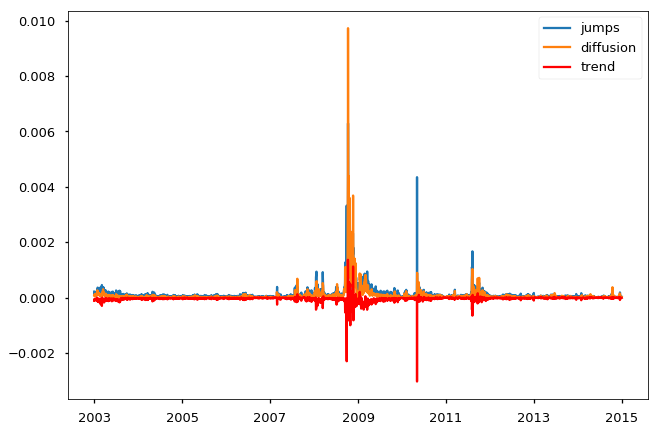

In [104]:
trend_fig, trend_ax = mpl.pyplot.subplots()
# trend_ax.plot(discrete_vol['diffusion'].apply(np.sqrt).dropna().values, zorder=-10)
trend_ax.plot(trend.dropna().index, discrete_vol['jumps'].dropna(), zorder=1)
trend_ax.plot(trend.dropna().index, discrete_vol['diffusion'].dropna(), zorder=1)
trend_ax.plot(trend.dropna().index, trend.values, label='trend', zorder=10, color='red')
trend_ax.legend()

In [105]:
trend.describe()

trend
count  3.0210e+03
mean  -3.6991e-05
std    1.0514e-04
min   -3.0276e-03
25%   -4.4050e-05
50%   -2.1325e-05
75%   -9.6717e-06
max    1.3672e-03

In [106]:
discrete_vol.count()

diffusion    3021
jumps        3021
dtype: int64

In [107]:
trend.count()

trend    3021
dtype: int64

In [108]:
data = pd.concat([daily_rtn, discrete_vol, trend], axis=1).rename(columns={0:'trend'})

In [109]:
data.head()

daily_rtn   diffusion   jumps       trend
DATE_TIME                                            
2003-01-02     0.0256  8.6422e-05  0.0002 -1.1414e-04
2003-01-03    -0.0007  1.0251e-04  0.0002 -5.3537e-05
2003-01-04        NaN         NaN     NaN         NaN
2003-01-05        NaN         NaN     NaN         NaN
2003-01-06     0.0220  5.5264e-05  0.0001 -5.6012e-05

In [110]:
data['jump_deviations'] = sm.OLS.from_formula('jumps ~ trend', data=data).fit().resid
data['diffusion_devaitions']= sm.OLS.from_formula('diffusion ~ trend', data=data).fit().resid

In [111]:
data['jump_temp_prop'] = data['jump_deviations'] / discrete_vol.sum(axis=1)
data['jump_prop'] = discrete_vol['jumps'] / discrete_vol.sum(axis=1)

In [112]:
discrete_vol.apply(np.log).corr()

diffusion   jumps
diffusion     1.0000  0.9027
jumps         0.9027  1.0000

In [113]:
def make_long_memory_coeffs(d, max_k):
    return np.asarray([(-1)**(k-1) * special.binom(np.real(d), k) for k in range(1, max_k+1)])

In [19]:
long_mem_dim = 22
class CommonFactor(sm.tsa.statespace.MLEModel):
    
    def __init__(self, endog):
               
        super(CommonFactor, self).__init__(endog, k_factors=1, k_states=long_mem_dim+2, k_posdef=3,factor_order=1,
                                           initialization='approximate_diffuse')        
        self.ssm['selection', 0, 0] = 1       
        self.ssm['selection', 1,1] = 1
        self.ssm['selection', 2, 2] = 1
        self.ssm['design', 0,0] = 1
        self.ssm['design', 0,1] = 1
        self.ssm['design', 1, 0] = 1
        self.ssm['design', 1, 2] = 1
        
        self.ssm['transition', 3, 0] = 1
        
        for i in range(long_mem_dim-2):
            self.ssm['transition', 4+i,4+i] = 1 
        
#         self.ssm['transition', long_mem_dim+2,1] = 1
        
    def update(self, params, *args, **kwargs):
    
        long_memory_params = make_long_memory_coeffs(params[0], long_mem_dim)
        self.ssm['transition', 0,0] = params[9]
        self.ssm['transition', 0, 3:long_mem_dim+2] = long_memory_params[1:]

#         self.ssm['transition', 0, 3] += params[11]

#         self.ssm['transition',1, long_mem_dim+2] = params[10]

        self.ssm['transition', 1, 1] = params[7]
        self.ssm['transition', 2, 2] = params[8]
        
        
        self.ssm['design', 1, 0] = params[2]
        
        self.ssm['obs_intercept', 0] = params[3]
        self.ssm['obs_intercept', 1] = params[4]
        
        self.ssm['state_cov', 0, 0] = params[1]
        self.ssm['state_cov', 1,1] = params[5]
        self.ssm['state_cov', 2,2] = params[6]
        
        self.ssm['state_cov', 1,0] = params[10] * np.sqrt(abs(params[5] * params[1]))
        self.ssm['state_cov', 0,1] = params[10] * np.sqrt(abs(params[5] * params[1]))

        
    @property
    def start_params(self):
        return ([.6, .13, 1] + list(np.mean(self.endog, axis=0)) 
                + [.01, .05] + [.4, 0, .7] 
                + [.67])
    
    @property
    def param_names(self):
        return (['d', 'trend_var', 'jump_loading'] + ['diff_intercept', 'jump_intercept'] 
                + ['diff_var','jump_var'] + ['diff_ar1', 'jump_ar1'] + ['trend_ar1'] 
                + ['diff_trend_corr'])

In [20]:
data = discrete_vol.apply(np.log).dropna()

In [21]:
bounds = ([(0,.7)] + [(0,None)]*2  + [(None, None)]*2
          + [(0, None)]*2 + [(None, None)]*2 + [(0, 1)]
          + [(-1,1)])

In [22]:
len(bounds)

11

In [23]:
factor_model = CommonFactor(data).fit(method='lbfgs', cov_type='robust', bounds=bounds, maxiter=2000, 
                                     cov_kwds={'approx_centered':True})

/home/sangrey/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [24]:
factor_model.mle_retvals

{'converged': False,
 'fcalls': 576,
 'fopt': nan,
 'gopt': array([ -3.3962e-02,   3.8323e-01,   8.2272e-02,  -7.0932e-05,
          9.0907e-05,   5.1916e-01,  -6.5859e-02,  -2.1010e-01,
         -1.3368e-01,   3.8298e-01,   2.1935e-01]),
 'warnflag': 2}

In [114]:
factor_model.llf

-3459.7535308802485

In [115]:
pd.DataFrame(np.squeeze(factor_model.filter_results.transition)[:6,:6])

0       1       2       3       4       5
0  0.8575  0.0000  0.0000  0.1214  0.0573  0.0346
1  0.0000  0.4047  0.0000  0.0000  0.0000  0.0000
2  0.0000  0.0000  0.0394  0.0000  0.0000  0.0000
3  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000
4  0.0000  0.0000  0.0000  0.0000  1.0000  0.0000
5  0.0000  0.0000  0.0000  0.0000  0.0000  1.0000

In [119]:
results = pd.DataFrame(factor_model.filter_results.smoothed_state.T[:,:3], index=data.dropna().index, 
             columns=['trend', 'diffusion', 'jumps'])

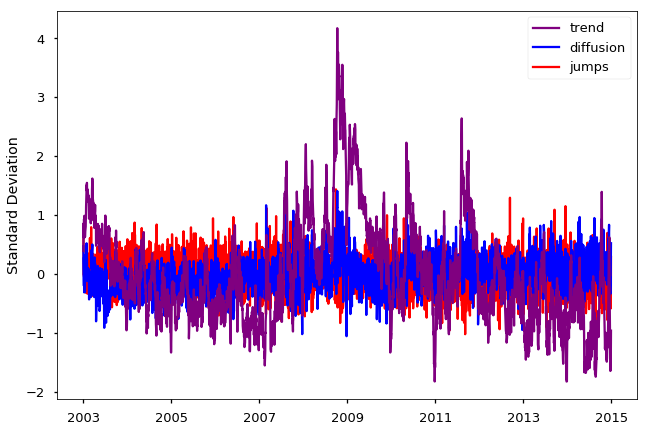

In [148]:
kalman_trend_fig, kalman_trend_ax = mpl.pyplot.subplots()
kalman_trend_ax.plot(results['trend'], color='purple', zorder=10)
kalman_trend_ax.plot(results['diffusion'], color='blue', zorder=2)
kalman_trend_ax.plot(results['jumps'], color='red', zorder=1)
kalman_trend_ax.legend()
kalman_trend_ax.set_ylabel('Standard Deviation')
kalman_trend_fig.savefig('../doc/figures/kalman_trend.tmp.pdf', transparent=True, bbox_inches='tight',
                         frameon=False, pad_inches=0)

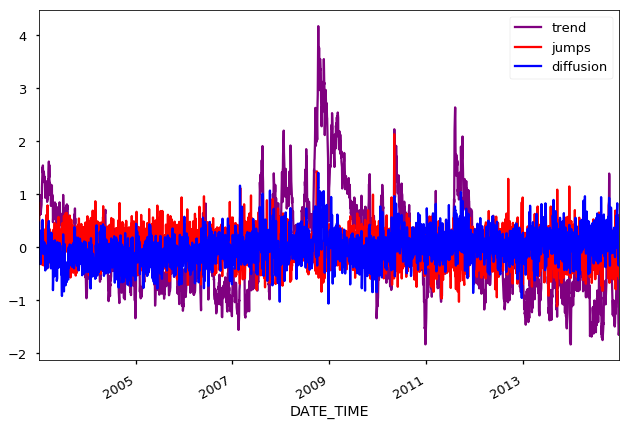

In [120]:
results[['trend', 'jumps', 'diffusion']].plot(color=['purple', 'red', 'blue'])

In [118]:
results.describe()

NameError: name 'results' is not defined

In [ ]:
results.var()

In [ ]:
jumps2 = pd.concat([sm.OLS(data['jumps'], data['diffusion']).fit().resid, results['jumps']], axis=1)

In [ ]:
jumps2.plot()

In [ ]:
jumps2.sort_values(by='jumps', ascending=False).head(10)

In [ ]:
stats.pearsonr(jumps2.iloc[:,0], jumps2.iloc[:,1])

In [ ]:
factor_model.summary()

In [ ]:
factor_data = pd.DataFrame(factor_model.filter_results.smoothed_state[:3,:].T,
                          index=data.index, columns=['trend', 'diffusion', 'jumps'])

In [ ]:
factor_data.diff().sort_values(by='trend', ascending=False).head()

In [ ]:
factor_data.corr()

In [ ]:
stats.describe(factor_data)

In [ ]:
sm.tsa.ARMA(factor_data['trend'], order=(5,0)).fit().summary2()

In [ ]:
sm.tsa.ARMA(factor_data['diffusion'], order=(1,0)).fit().summary2()

In [ ]:
sm.tsa.ARMA(factor_data['jumps'], order=(1,0)).fit().summary2()

In [ ]:
sm.tsa.VAR(factor_data).fit(maxlags=3, trend='nc').summary()

In [ ]:
from bayesiankalman import kalmanfilter as kf
from bayesiankalman import kalmanfilter as kf
factor_model.impulse_responses(30, 0).plot()

In [ ]:
factor_model.impulse_responses(30, 1).plot()

In [ ]:
factor_model.impulse_responses(30, 2).plot()

## Comparison with VIX

In [ ]:
vix = pd_data.get_data_fred('VIXCLS', start='1950', end='2018').rename(columns={'VIXCLS':'vix'})


In [ ]:
vix_comp = pd.concat([vix, results], axis=1)
vix_comp['quad'] = discrete_vol['jumps'] + discrete_vol['diffusion']
vix_comp['diff'] = ((vix_comp['vix'] / 100)**2 - vix_comp['quad']**2 * 252).apply(np.log)
vix_comp['daily_rtn'] = daily_rtn

In [ ]:
sm.OLS.from_formula('diff ~ trend + diffusion + jumps', vix_comp).fit(
    cov_type='HAC', cov_kwds={'maxlags':12}).summary2()

In [ ]:
sm.WLS.from_formula('daily_rtn ~ trend + diffusion + jumps', vix_comp, weights=vix_comp['quad']).fit().summary2()

In [ ]:
discrete_vol.head()

In [ ]:
data.head()

In [ ]:
sm.WLS.from_formula('daily_rtn ~ diffusion.apply(np.log) + jumps.apply(np.log)',  
                    pd.concat([discrete_vol, daily_rtn], axis=1).dropna(),
                    weights=(discrete_vol['diffusion'] + discrete_vol['jumps']).dropna()).fit().summary2()

In [ ]:
discrete_vol.apply(np.log).head()

In [ ]:
discrete_vol.apply(np.log).apply(np.square).head()

In [ ]:
eqn1 = """daily_rtn ~ diffusion.apply(np.log) + diffusion.apply(np.log).apply(np.square) + jumps.apply(np.log) 
                    + jumps.apply(np.log).apply(np.square) + jumps.apply(np.log) * diffusion.apply(np.log)"""
sm.WLS.from_formula(eqn1, pd.concat([discrete_vol, daily_rtn], axis=1).dropna(),
                    weights=(discrete_vol['diffusion'] + discrete_vol['jumps']).dropna()).fit().summary2()

In [ ]:
eqn1 = """daily_rtn ~ log_jump_prob + log_jump_prob.apply(np.square)"""
log_jump_prob = discrete_vol['jumps'].apply(np.log) - (discrete_vol['jumps'] 
                                                       + discrete_vol['diffusion']).apply(np.log)
sm.WLS.from_formula(eqn1, pd.concat([log_jump_prob, daily_rtn], axis=1).rename(columns={0:'log_jump_prob'}),
                    ).fit().summary2()

In [ ]:
daily_rtn_decomp = sm.tsa.VAR(pd.concat([data, daily_rtn], axis=1).dropna()).fit(maxlags=22)

In [ ]:
1 - np.var(daily_rtn_decomp.resid['daily_rtn']) / np.var(daily_rtn)

In [ ]:
daily_rtn_decomp.sigma_u_mle

In [ ]:
daily_rtn_irfs = daily_rtn_decomp.irf(periods=10, var_decomp=scilin.cholesky(daily_rtn_decomp.sigma_u).T).orth_irfs[:,-1,:]
daily_rtn_irfs_df = pd.DataFrame(daily_rtn_irfs, columns=['diffusion', 'jumps', 'daily_rtn'])

In [ ]:
daily_rtn_irfs_df.plot()

In [ ]:
daily_rtn_decomp.fevd(periods=120, var_decomp=scilin.cholesky(daily_rtn_decomp.sigma_u).T).plot()